## Histopathologic Cancer CNN Notebook

### Section 1: Problem and Data Description

This is a binary image classification problem where you will identify metastatic cancer in small image patches taken from larger digital pathology scans.

The task is to classify histopathologic scans of lymph node sections as containing metastatic cancer (label=1) or not (label=0). The dataset consists of:
- **Training images**: ~220,000 labeled .tif images, 96x96 pixels, RGB
- **Test images**: ~57,000 unlabeled images
- **Labels file**: CSV file mapping image IDs to labels

The goal is to build a CNN model to predict the presence of cancer in unseen images, evaluated on a classification metrics. specifically Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.



### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

#### Import Statements and Setup

In [1]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-10-14 21:45:53.539830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DATA_DIR = Path('input')
TRAIN_DIR = './train'
TEST_DIR = './test'
LABELS_CSV = './train_labels.csv'

labels = pd.read_csv(LABELS_CSV)

#### Analysis of Class Distribution

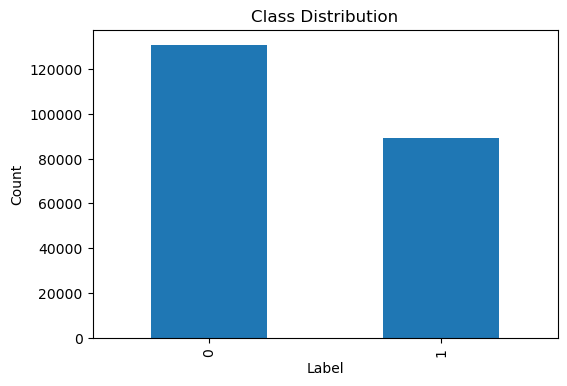

In [3]:
plt.figure(figsize=(6,4))
labels['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


We can see that there's a slight imbalance between the positive(1) and negative(0) labels, because they are not exactly evenly distributed, but overall the data appears to be balanced enough that we might not have to adjust for this.

#### Sampling a few of the images for analysis

In [6]:
sample_ids = labels.sample(6, random_state=SEED)['id'].tolist()
plt.figure(figsize=(12,6))

# testpath = './train/0a4d72220c0d4e0555c2d3e396208d7f262f48f9.tif'
# print("test path is: "+testpath)
# img = Image.open(testpath)


for i, img_id in enumerate(sample_ids):
    img_path = "./train/"+img_id+'.tif'
    print("img_path = "+img_path)
    img = Image.open(img_path)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample Images')
plt.show()

img_path = ./train/d293308913e4a40cebb809d986aa9add65a76bfa.tif


FileNotFoundError: [Errno 2] No such file or directory: './train/d293308913e4a40cebb809d986aa9add65a76bfa.tif'

<Figure size 1200x600 with 0 Axes>

In [ ]:
#### Shape of data

#### EDA conclusion:
- Classes are balanced enough to begin modelling without needing to correct for imbalances for now. If model performance suffers, it might be work correcting for this in the next iteration (i.e. extrapolate to create a labelled dataset where num(labels=1) == num(labels=2).
- Dimensions
- Sample images are

### Section 3: Model Architecture

##### Justification of model choice:

Rationale:

- Multiple convolutional layers capture spatial features (i.e. edges, colour gradient within the first layer or so, but then working deeper into determining tissue irregularities, etc, in further layers.)
- MaxPooling reduces dimensionality, which contradicts above, but might make this model easier to run on my local machine, and may reduce noise.
- Dropout prevents expected overfitting due to the small image sizes, and potentially the lack of variability in the images.
- Simple CNNs tend to suit small images and smaller classification tasks (binary)


In [ ]:
input_shape = (96,96,3)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Simple CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),
    BatchNormalization(),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

### Section 4: Results and Analysis

In [ ]:
# Data augmentation
#I'm only estimating a bit here, based on results we can tweak a bit.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

#change dtype of y_col to string
labels["label_str"] = labels["label"].astype('str')
labels['id_filename'] = labels['id'] + '.tif'

train_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='./train',
    x_col='id_filename',
    y_col='label_str',
    subset='training',
    batch_size=32, #change this to experiment with batch_sizing
    seed=SEED,
    shuffle=True,
    class_mode='binary',
    target_size=(96,96),
    color_mode='rgb'
)


val_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='./train',
    x_col='id_filename',
    y_col='label_str',
    subset='validation',
    batch_size=32,
    seed=SEED,
    shuffle=False,
    class_mode='binary',
    target_size=(96,96),
    color_mode='rgb'
)

# Training
#Let's experiment a bit with the number of epochs, as it'll take forever locally otherwise.
#Medium number of epochs is probably better for the purposes of this dataset?
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3 # This training is extremely slow on my machine, so we have to go smaller than I'd like.
)